In [1]:
import pandas as pd
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [2]:
def get_node_path(start_node):
    if start_node <= max(int_to_cluster.keys()):
        cluster = int_to_cluster[start_node]
    else:
        # take any child
        cluster = list(node_dict[start_node]['left'])[0]
        
    nodes = [start_node]
    for k, v in node_dict.items():
        if k < start_node:
            continue
        else:
            if cluster in (v['left'] | v['right']):
                nodes.append(k)
    node_path = sorted(nodes, reverse=True)
    return node_path

def straight_branch(ax, a, b, plot_kws, vertical=False):
    """Draw link line between a and b"""
    a_x, ay = a
    bx, by = b
    if vertical:
        branch_x = [a_x, a_x, bx]
        branch_y = [ay, by, by]
    else:
        branch_x = [a_x, bx, bx]
        branch_y = [ay, ay, by]
    if plot_kws is None:
        plot_kws = {}
    return ax.plot(branch_x, branch_y, **plot_kws)


def plot_dendrogram(
        linkage_df,
        labels_list,
        dendro_dict,
        ax=None,
        branch_type='straight',
        plot_node_id=False,
        plot_kws=None,
        node_hue=None,
        node_hue_norm=None,
        node_palette=None,
        palette='viridis',  # shared by both line and node hue
        node_size=None,
        node_size_norm=None,
        line_hue=None,
        line_hue_norm=None,
        sizes=None,
        size=30,
        linewidth=1,
        color=None,
        vertical=False,
        highlight_node_path=None):
    if plot_kws is None:
        plot_kws = {}

    dendro = dendro_dict
    n_leaves = len(dendro['leaves'])

    node_pos = {}  # all node including singleton and non-singleton
    for leaf_x, leaf in enumerate(dendro['leaves']):
        node_pos[int(leaf)] = (leaf_x, 0)

    direct_link_map = {}  # node linkage, keys only contain non-singleton
    for i, (left, right, height, _) in linkage_df.iterrows():
        node_id = int(i + linkage_df.shape[0] + 1)
        left = int(left)
        right = int(right)
        node_x = (node_pos[left][0] + node_pos[right][0]) / 2
        node_pos[node_id] = [node_x, height]
        direct_link_map[node_id] = [int(left), int(right)]

    if branch_type == 'straight':
        branch_plot_function = straight_branch
    else:
        raise

    # node colors
    nan_color = '#D3D3D3' if color is None else color
    if node_hue is not None:
        if node_hue_norm is None:
            values = node_hue.values()
            _hue_norm = Normalize(vmin=min(values), vmax=max(values))
        else:
            _hue_norm = Normalize(vmin=min(node_hue_norm),
                                  vmax=max(node_hue_norm))
        _cmap = get_cmap(palette)

        def node_cmap(v):
            return (_cmap(_hue_norm(v)), )
    else:
        node_hue = {}

        def node_cmap(_):
            raise

    node_colors = {
        node: node_cmap(node_hue[node]) if (node in node_hue) else nan_color
        for node in node_pos.keys()
    }
    
    if node_palette is not None:
        node_colors = node_palette
        
    if highlight_node_path:
        nodes = get_node_path(highlight_node_path)
        node_colors = {
            node: 'red' if (node in nodes) else node_colors[node]
            for node in node_pos.keys()
        }
    

    # node sizes
    nan_size = size
    if node_size is not None:
        if sizes is None:
            nan_size = 10
            sizes = (10, 80)
        else:
            nan_size = sizes[0]

        if node_size_norm is None:
            values = node_size.values()
            _size_norm = Normalize(vmin=min(values), vmax=max(values))
        else:
            _size_norm = Normalize(vmin=min(node_size_norm),
                                   vmax=max(node_size_norm))

        def node_smap(v):
            v_norm = _size_norm(v)
            v_norm = min(1, max(0, v_norm))  # limit norm value to [0, 1]
            s = v_norm * (sizes[1] - sizes[0]) + sizes[0]
            return s
    else:
        node_size = {}

        def node_smap(_):
            raise

    node_sizes = {
        node: node_smap(node_size[node]) if (node in node_size) else nan_size
        for node in node_pos.keys()
    }

    if vertical:
        node_pos = {k: v[::-1] for k, v in node_pos.items()}

    for node_id, (node_x, node_y) in node_pos.items():
        ax.scatter(node_x,
                   node_y,
                   s=node_sizes[node_id],
                   c=node_colors[node_id],
                   zorder=10-node_y)

    # line color
    nan_color = '#D3D3D3' if color is None else color
    if line_hue is not None:
        if line_hue_norm is None:
            values = line_hue.values()
            _hue_norm = Normalize(vmin=min(values), vmax=max(values))
        else:
            _hue_norm = Normalize(vmin=min(line_hue_norm),
                                  vmax=max(line_hue_norm))
        _cmap = get_cmap(palette)

        def line_cmap(v):
            return _cmap(_hue_norm(v))
    else:
        line_hue = {}

        def line_cmap(_):
            raise

    line_colors = {
        node: line_cmap(line_hue[node]) if (node in line_hue) else nan_color
        for node in node_pos.keys()
    }
    
    if highlight_node_path:
        nodes = get_node_path(highlight_node_path)
        line_colors = {
            node: 'red' if (node in nodes) else nan_color
            for node in node_pos.keys()
        }
        
    
    ymax = 0
    xmax = 0
    for node_id, (node_x, node_y) in node_pos.items():
        # plot node id text
        if plot_node_id:
            if node_id >= n_leaves:
                ax.text(node_x,
                        node_y,
                        node_id,
                        fontsize=4 if 'fontsize' not in plot_kws else
                        plot_kws['fontsize'],
                        ha='center',
                        va='center',
                        c='k', zorder=100)
            else:
                ax.text(node_x,
                        -0.01,
                        node_id,
                        fontsize=4 if 'fontsize' not in plot_kws else
                        plot_kws['fontsize'],
                        ha='center',
                        va='center',
                        c='k', zorder=100)

        # plot branch
        # only non-singleton node has branch:
        if node_id in direct_link_map:
            # get child
            left_child, right_child = direct_link_map[node_id]
    
            # plot left branch
            branch_plot_function(ax, (node_x, node_y),
                                 node_pos[left_child],
                                 plot_kws=dict(c=line_colors[left_child],
                                               linewidth=linewidth),
                                 vertical=vertical)
    
            # plot right branch
            branch_plot_function(ax, (node_x, node_y),
                                 node_pos[right_child],
                                 plot_kws=dict(c=line_colors[right_child],
                                               linewidth=linewidth),
                                 vertical=vertical)
    if vertical:
        xmax = max(xmax, node_x)
        ax.set_xlim(xmax * 1.05, 0 - xmax * 0.05)
        
    else:
        ymax = max(ymax, node_y)
        ax.set_ylim(0 - ymax * 0.05, ymax * 1.05)
    return node_pos, dendro

In [3]:
output_dir = '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/ExcGeneToTree/'

use_clusters = [
    'CA3 Cadm2', 'CA1 Chrm3', 'CA3-St18 Tead1', 'Gfra1 Gfra1', 'IT-L5 Etv1',
    'CA1 Ptprg', 'NP-L6 Cntnap4', 'CA3-St18 Nuak1', 'CT-L6 Megf9',
    'IG-CA2 Chrm3', 'IG-CA2 Peak1', 'DG-po Calb2', 'DG dg-all', 'CA1 Kif26a',
    'CA3 Efnb2', 'CA1 Ak5', 'DG-po Bcl11a', 'PT-L5 Tenm2', 'CA1 Lingo2',
    'CA3-St18 Epha5', 'IG-CA2 Xpr1', 'DG-po Kctd8', 'CT-L6 Il1rap',
    'L6b Adcy8', 'IT-L6 Man1c1', 'NP-L6 Olfml2b', 'PT-L5 Abca12',
    'PT-L5 Nectin1', 'IT-L23 Cux1', 'IT-L23 Foxp1', 'IT-L4 Shc3', 'IT-L5 Cdh8',
    'IT-L5 Grik3', 'PT-L5 Tmtc2', 'IT-L23 Tenm2', 'NP-L6 Cntnap5a',
    'CT-L6 Hcrtr2', 'PT-L5 Plcb4', 'IT-L23 Ptprt', 'CT-L6 Map4', 'NP-L6 Boc',
    'PT-L5 Kcnh1', 'OLF-Exc Bmpr1b', 'PT-L5 Astn2', 'IT-L6 Fstl4',
    'CLA Bcl11a', 'NP-L6 Cyp7b1', 'CLA Cdh8', 'IT-L6 Cadps2', 'PT-L5 Ptprt',
    'NP-L6 Kcnab1', 'IT-L6 Oxr1', 'OLF-Exc Pld5', 'OLF-Exc Lrrtm3',
    'OLF-Exc Cdh9', 'OLF-Exc Unc13c', 'L6b Nrp2', 'OLF-Exc Sgcd',
    'OLF-Exc Rmst', 'PT-L5 Unc5b', 'L6b Pkhd1', 'L6b Kcnk2', 'IT-L4 Astn2',
    'CLA Nrp2', 'EP Tspan5', 'OLF-Exc Cux2', 'EP Rgs8', 'EP Adcy8'
]

In [4]:
dendro = joblib.load(f'{output_dir}/Dendrogram.lib')
linkage = pd.read_csv(f'{output_dir}/Linkage.csv', header=None)
node_dict = joblib.load(f'{output_dir}/non_singleton_node_dict.lib')
subtype_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

In [5]:
int_to_cluster = {i: cluster for i, cluster in zip(dendro['leaves'], dendro['ivl'])}

In [6]:
node_palette = {}
for leaf, cluster in zip(dendro['leaves'], dendro['ivl']):
    node_palette[leaf] = subtype_palette[cluster]
    
upper_nodes = linkage.shape[0]
for i in range(upper_nodes):
    upper_node_id = upper_nodes + i + 1
    node_palette[upper_node_id] = '#D3D3D3'

[[], []]

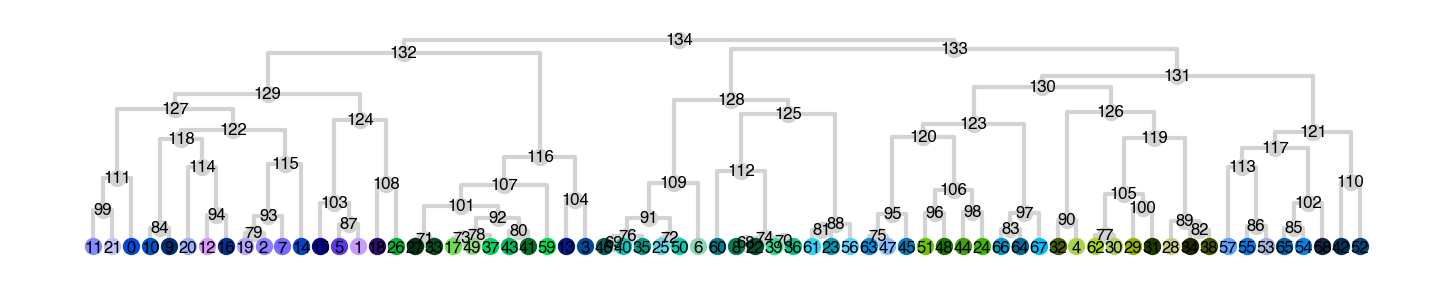

In [7]:
fig, ax = plt.subplots(figsize=(6, 1), dpi=300)

plot_dendrogram(linkage_df=linkage,
                labels_list=use_clusters,
                dendro_dict=dendro,
                ax=ax,
                size=10,
                node_palette=node_palette,
                plot_node_id=True,
                vertical=False)
sns.despine(ax=ax, left=True, bottom=True)
ax.set(xticks=[], yticks=[])

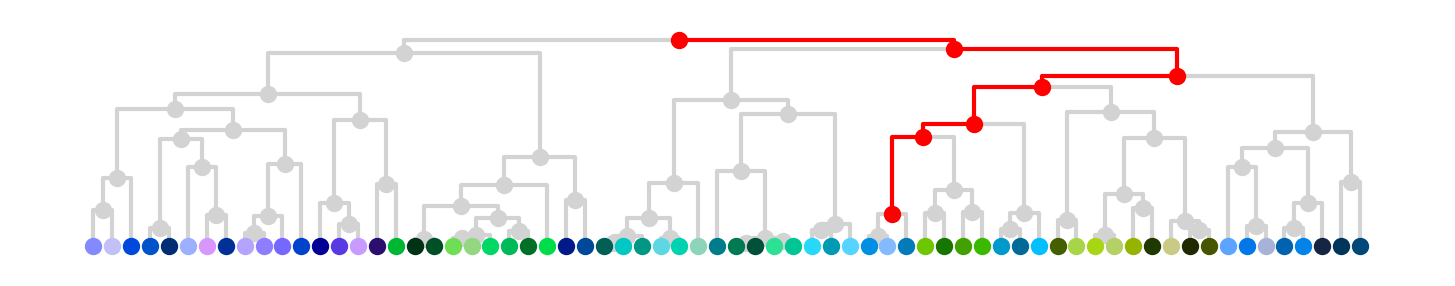

In [8]:
fig, ax = plt.subplots(figsize=(6, 1), dpi=300)

node = 95
plot_dendrogram(linkage_df=linkage,
                labels_list=use_clusters,
                dendro_dict=dendro,
                ax=ax,
                size=10,
                node_palette=node_palette,
                plot_node_id=False,
                vertical=False,
                highlight_node_path=node)
sns.despine(ax=ax, left=True, bottom=True)
ax.set(xticks=[], yticks=[])
fig.savefig(f'ExcTree.node{node}.pdf')

In [9]:
from scipy.cluster.hierarchy import dendrogram

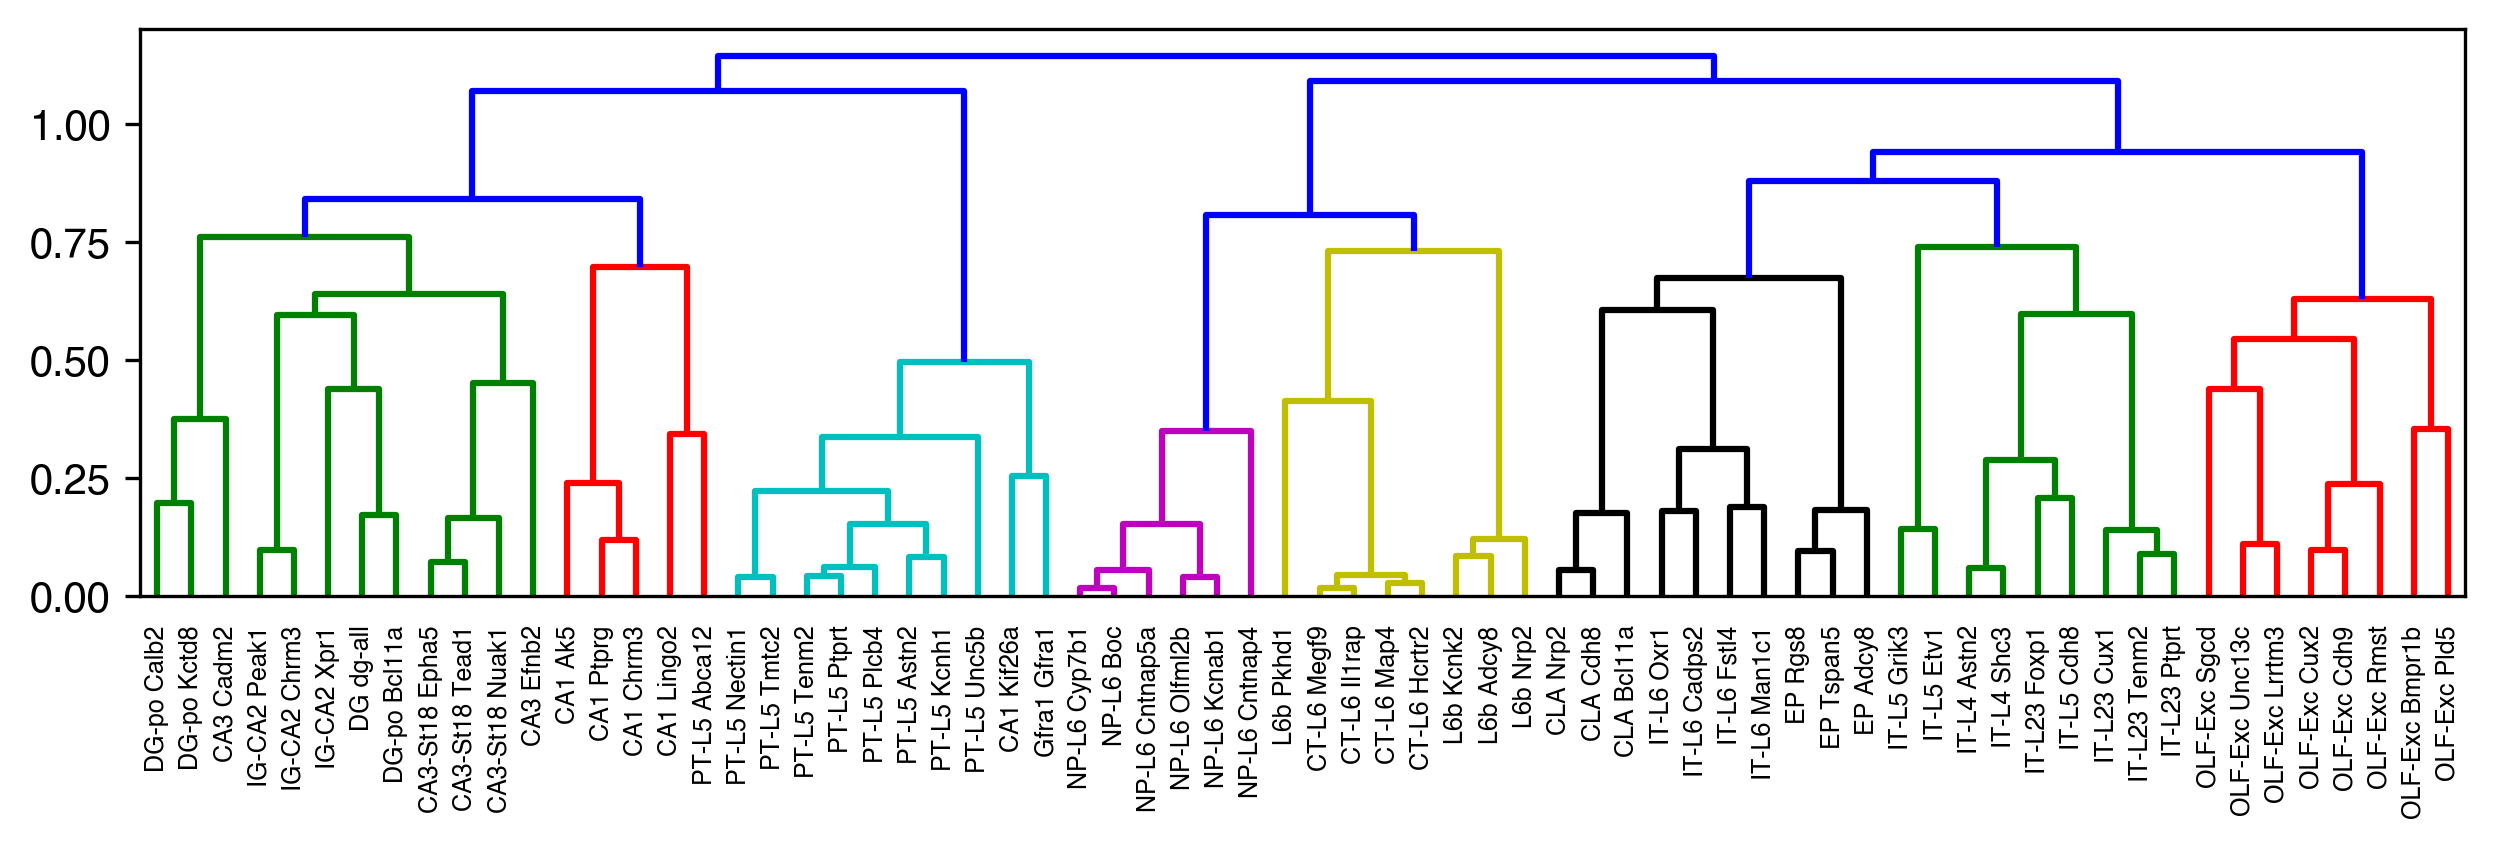

In [10]:
fig, ax = plt.subplots(figsize=(10, 2.5), dpi=300)
dendrogram(linkage, labels=pd.Series(int_to_cluster).sort_index().values)
pass

In [20]:
import numpy as np
def barplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None,
            estimator=np.mean, ci=95, n_boot=1000, units=None, seed=None,
            orient=None, color=None, palette=None, saturation=.75,
            errcolor=".26", errwidth=None, capsize=None, dodge=True,
            ax=None, **kwargs):

    plotter = _BarPlotter(x, y, hue, data, order, hue_order,
                          estimator, ci, n_boot, units,
                          orient, color, palette, saturation,
                          errcolor, errwidth, capsize, dodge)
    plotter.width=1
    if ax is None:
        ax = plt.gca()

    plotter.plot(ax, kwargs)
    return ax

from seaborn.categorical import _BarPlotter

In [21]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)
region_order = ['MOB', 'AON', 'PIR', 'ORB', 'PFC', 'AI', 'ACA', 'MOs', 'MOp', 'SSp', 'SSs', 
       'CA1-3', 'DG', 'CP', 'ACB', 'PAL', 'LSX']

cell_counts = cell_tidy_data.groupby('SubType')['SubRegion'].value_counts().unstack().fillna(0)
cell_rates = cell_counts / cell_counts.sum(axis=1)[:, None]

bar_data = []
for cluster, row in cell_rates[region_order].iterrows():
    record = row[row > 0].cumsum().reset_index()
    record['SubType'] = cluster
    record.columns = ['Region', 'value', 'SubType']
    bar_data.append(record)
bar_data = pd.concat(bar_data)


sub_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


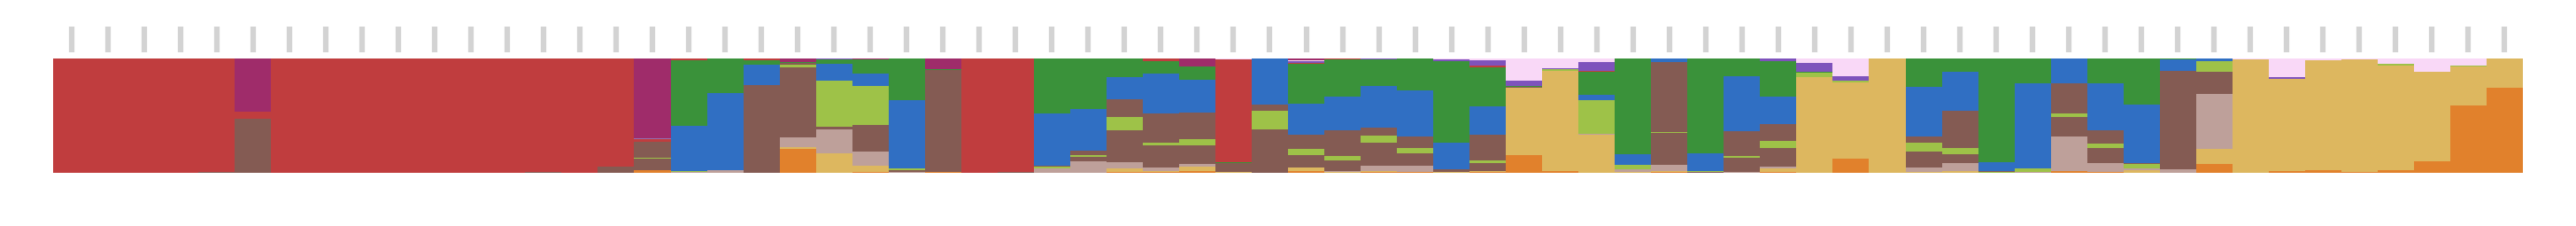

In [22]:
fig, ax = plt.subplots(figsize=(6, 0.3), dpi=600)

barplot(ax=ax, data=bar_data, 
            x='SubType', y='value', order=dendro['ivl'],
            hue='Region', dodge=False, palette=sub_region_palette, 
            hue_order=region_order[::-1])

sns.despine(left=True, bottom=True)
ax.set(yticks=[], xticklabels=[], xlabel='', ylabel='')
ax.xaxis.tick_top()
ax.set_xticks(range(len(dendro['ivl'])))
ax.xaxis.set_tick_params(width=0.75, color='lightgray')
ax.legend_.set_visible(False)